# Tutorial 3: Human bone marrow (ATAC-seq + proteins)

Tutorial 3 studies a human bone marrow dataset from [Mimitou et al., 2021](https://www.nature.com/articles/s41587-021-00927-2) showing the differentiation of hematopoietic stem cells to multiple developmental fates.

## Loading and preprocessing data

The dataset has two modalities: ATAC-seq and proteins (raw data is available [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE156478)). We use count matrices preprocessed by the dataset authors, available [here](https://github.com/caleblareau/asap_reproducibility/tree/master/bonemarow_asapseq/output/for_total_vi_asap_marrow/filtered_feature_bc_matrix). We converted them into annotated matrices, which you can download [here](LINK).

First, load the ATAC-seq annotated matrix.

In [1]:
import anndata as ad
from os.path import join

# a path to the folder with data
source_path = './'
atacseq = ad.read_h5ad(join(source_path, 'human_bone_marrow_ATACseq.h5ad'))

atacseq

AnnData object with n_obs × n_vars = 10927 × 3000
    obs: 'celltype'
    var: 'modality'

The ATAC-seq count matrix comprises 10,927 cells and 3,000 genes (achieved by mapping chromatin accessibility fragments to gene regions with [Signac](https://stuartlab.org/signac/index.html)).

Compute LDA topics for training MDM.

In [2]:
import ocelli as oci

SEED = 17

oci.pp.LDA(atacseq, n_components=15, max_iter=50, random_state=SEED, verbose=1)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

Load the second modality, proteins.

In [3]:
proteins = ad.read_h5ad(join(source_path, 'human_bone_marrow_Proteins.h5ad'))

proteins

AnnData object with n_obs × n_vars = 10927 × 238
    obs: 'celltype'
    var: 'modality'

The proteins' count matrix consists of 238 protein tags.

Calculate LDA topics.

In [4]:
oci.pp.LDA(proteins, n_components=15, max_iter=50, random_state=SEED, verbose=1)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

## Multimodal Diffusion Maps

To prepare preprocessed modalities for MDM training, you must create a joint `AnnData` object. It must include modality matrices saved in `adata.obsm` and a list of their keys in `adata.uns`.

In [5]:
from scipy.sparse import csr_matrix

# empty AnnData object
adata = ad.AnnData(csr_matrix(([],([],[])), shape=(10927, 1000)))

# modality arrays
adata.obsm['ATAC-seq'] = atacseq.obsm['X_lda']
adata.obsm['Proteins'] = proteins.obsm['X_lda']
adata.uns['modalities'] = ['ATAC-seq', 'Proteins']

# cell metadata
adata.obs.index = list(atacseq.obs.index)
adata.obs['celltype'] = list(atacseq.obs['celltype'])

adata

AnnData object with n_obs × n_vars = 10927 × 1000
    obs: 'celltype'
    uns: 'modalities'
    obsm: 'ATAC-seq', 'Proteins'

To find the multimodal representation of the dataset, repeat the three-stage process from Tutorials 1 and 2: find nearest neighbors across modalities, calculate multimodal weights, and compute the MDM embedding.

In [6]:
oci.pp.neighbors(adata, n_neighbors=70, verbose=True)
oci.tl.weights(adata, random_state=SEED, verbose=True)
oci.tl.MDM(adata, n_components=10, random_state=SEED, verbose=True)

[ATAC-seq]	70 nearest neighbors calculated.
[Proteins]	70 nearest neighbors calculated.


2023-01-24 16:01:32,597	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


2023-01-24 16:01:39,295	INFO worker.py:1518 -- Started a local Ray instance.


[ATAC-seq]	Unimodal Markov chain calculated.
[Proteins]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
10 Multimodal Diffusion Maps components calculated.


## Visualizing MDM components

Reduce the dimensionality of MDM's latent space to 2 using UMAP and plot the resulting embedding.

In [7]:
oci.tl.UMAP(adata, x='X_mdm', n_components=2, n_neighbors=60, min_dist=0.075,
            random_state=SEED)

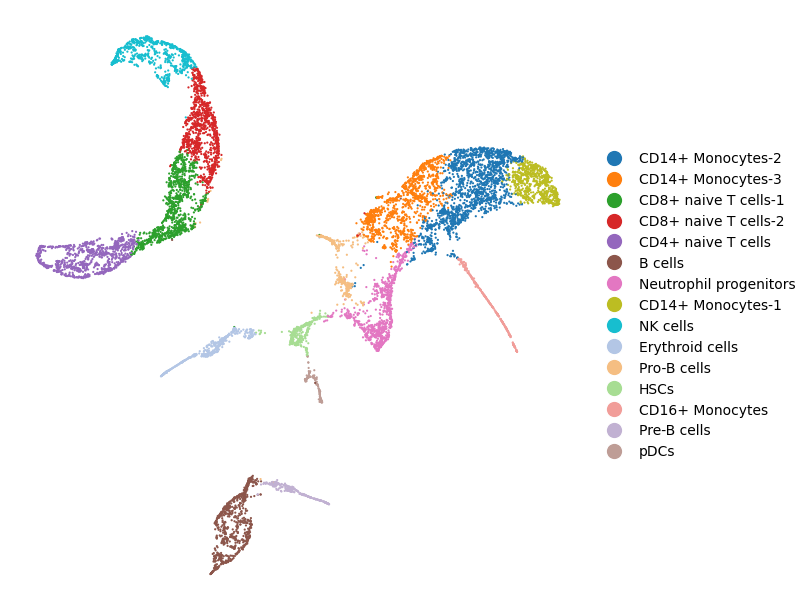

In [8]:
cdict = {'CD14+ Monocytes-2': '#1f77b4',
         'CD14+ Monocytes-3': '#ff7f0e',
         'CD8+ naive T cells-1': '#2ca02c',
         'CD8+ naive T cells-2': '#d62728',
         'CD4+ naive T cells': '#9467bd',
         'B cells': '#8c564b',
         'Neutrophil progenitors': '#e377c2',
         'CD14+ Monocytes-1': '#bcbd22',
         'NK cells': '#17becf',
         'Erythroid cells': '#b3c6e5',
         'Pro-B cells': '#f5be82',
         'HSCs': '#a7dd93',
         'CD16+ Monocytes': '#f19d99',
         'Pre-B cells': '#c1b1d2',
         'pDCs': '#be9d96'}

oci.pl.scatter(adata, x='X_umap', c='celltype', cdict=cdict, markersize=2.5, title='',
               fontsize=10, markerscale=2, figsize=(8, 6))

## Interpreting multimodal weights

Multimodal weight distribution shows that chromatin accessibility is more informative for:

* hematopoietic stem cells (HSCs),
* neutrophil progenitors,
* erythroid cells,
* plasmacytoid dendritic cells (pDCs).

Meanwhile, proteins are more informative for monocytes, T cells, or B cells.

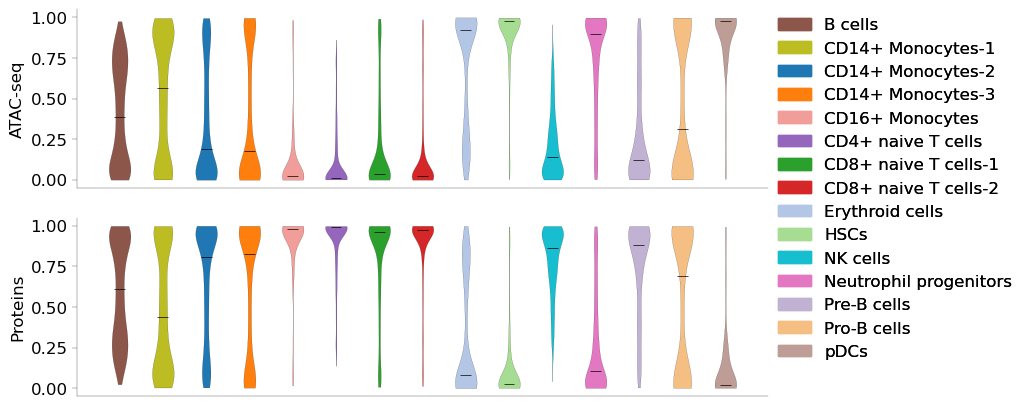

In [9]:
oci.pl.violin(adata, groups='celltype', values='weights', cdict=cdict, fontsize=12, 
              figsize=(10, 4))

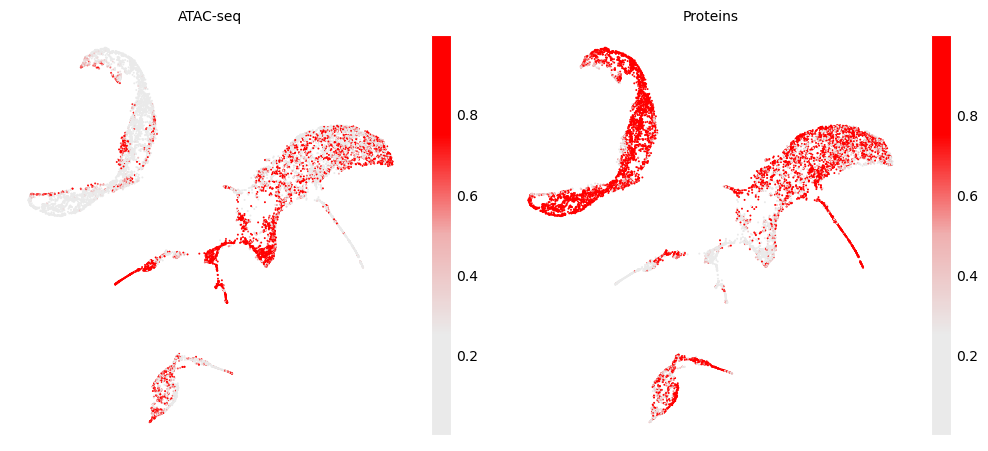

In [10]:
from matplotlib.colors import LinearSegmentedColormap

weights_cmap = LinearSegmentedColormap.from_list(
    'custom', ['#eaeaea', '#eaeaea', '#efb0b0', '#ff0000', '#ff0000'], N=256)

oci.pl.scatter(adata, x='X_umap', c='weights', cmap=weights_cmap, markersize=2, 
               fontsize=10, figsize=(10, 6))

## Investigating protein marker levels 

Similarly to gene signatures, protein markers are also an excellent tool for annotating cells. In this section, you will plot the normalized expression of selected markers.

Normalize the proteins' count matrix.

In [11]:
import scanpy as sc

sc.pp.normalize_total(proteins, target_sum=10000)

### CD14 (CD14+ Monocytes)

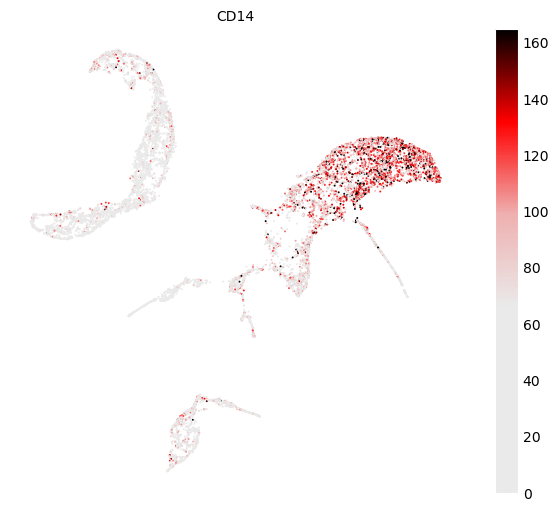

In [12]:
import numpy as np

cmap = LinearSegmentedColormap.from_list(
    'custom', ['#eaeaea', '#eaeaea', '#eaeaea', '#EFB0B0', '#FF0000', '#000000'], N=256)

# marker name
protein = 'CD14'
# save marker's normalized expression to adata.obs
adata.obs[protein] = proteins[:, protein].X.toarray()
# plot normalized expression
vmax = np.percentile(adata.obs[protein], 98)
oci.pl.scatter(adata, x='X_umap', c=protein, cmap=cmap, markersize=2, fontsize=10, 
               vmax=vmax, figsize=(8, 5))

### CD71 (Erythroid cells)

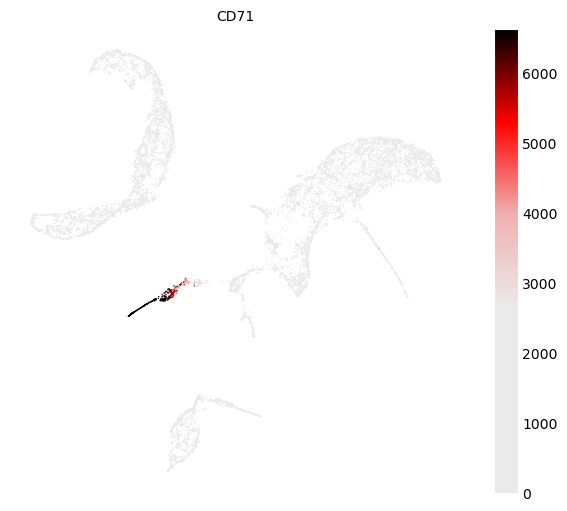

In [13]:
protein = 'CD71'
adata.obs[protein] = proteins[:, protein].X.toarray()

vmax = np.percentile(adata.obs[protein], 98)
oci.pl.scatter(adata, x='X_umap', c=protein, cmap=cmap, markersize=1, fontsize=10, 
               vmax=vmax, figsize=(8, 5))

### CD34 (Hematopoietic stem cells)

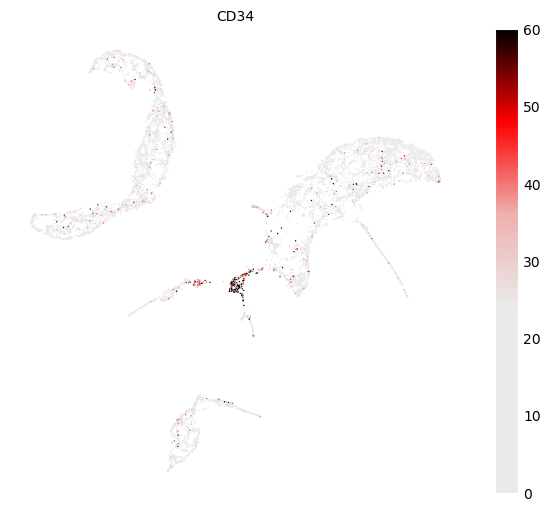

In [14]:
protein = 'CD34'
adata.obs[protein] = proteins[:, protein].X.toarray()

vmax = np.percentile(adata.obs[protein], 98)
oci.pl.scatter(adata, x='X_umap', c=protein, cmap=cmap, markersize=1, fontsize=10, 
               vmax=vmax, figsize=(8, 5))

### CD123 (Plasmacytoid dendritic cells)

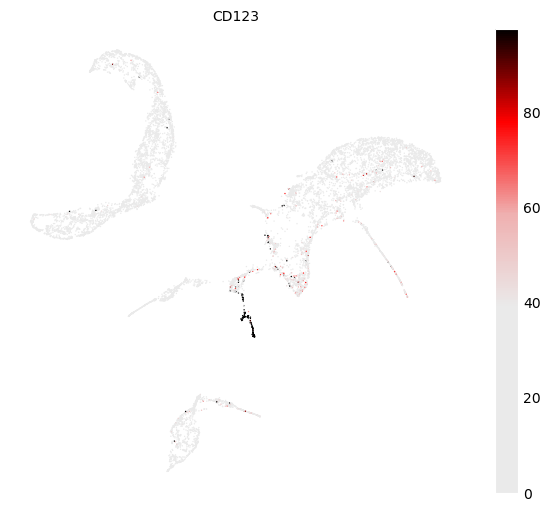

In [15]:
protein = 'CD123'
adata.obs[protein] = proteins[:, protein].X.toarray()

vmax = np.percentile(adata.obs[protein], 98)
oci.pl.scatter(adata, x='X_umap', c=protein, cmap=cmap, markersize=1, fontsize=10, 
               vmax=vmax, figsize=(8, 5))

### CD19 (B cells)

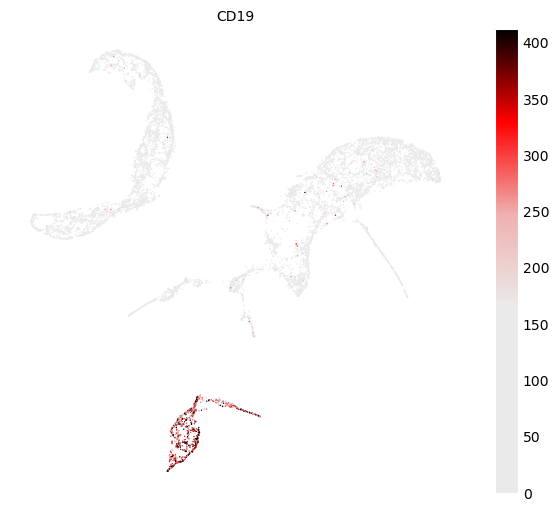

In [16]:
protein = 'CD19'
adata.obs[protein] = proteins[:, protein].X.toarray()

vmax = np.percentile(adata.obs[protein], 98)
oci.pl.scatter(adata, x='X_umap', c=protein, cmap=cmap, markersize=1, fontsize=10,
               vmax=vmax, figsize=(8, 5))

### CD4 (CD4+ naive T cells)

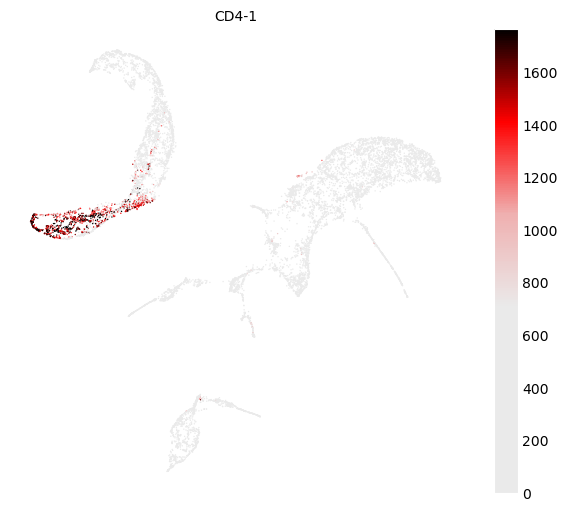

In [17]:
protein = 'CD4-1'
adata.obs[protein] = proteins[:, protein].X.toarray()

vmax = np.percentile(adata.obs[protein], 98)
oci.pl.scatter(adata, x='X_umap', c=protein, cmap=cmap, markersize=1, fontsize=10, 
               vmax=vmax, figsize=(8, 5))

### CD8 (CD8+ naive T cells)

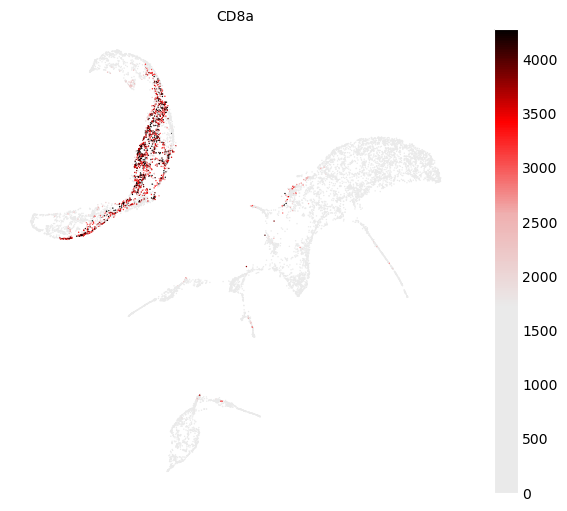

In [18]:
protein = 'CD8a'
adata.obs[protein] = proteins[:, protein].X.toarray()

vmax = np.percentile(adata.obs[protein], 98)
oci.pl.scatter(adata, x='X_umap', c=protein, cmap=cmap, markersize=1, fontsize=10, 
               vmax=vmax, figsize=(8, 5))

You've reached the end of Tutorial 3. In Tutorial 4, you will learn how to apply the multimodal analysis approach when data is unimodal.